In [1]:
from pocket_cube.cube import Cube
from pocket_cube.cube import Move
from heapq import heappop, heappush
from tests import *
%matplotlib ipympl
import matplotlib.pyplot as plt


In [26]:
import math


def heuristic(cube: Cube) -> int:
    sum = 0

    for i, x in enumerate(cube.state):
        if x != cube.goal_state[i]:
            sum += 1
    return sum

In [ ]:
import numpy as np

positions = {
    0: (0, 1),
    1: (1, 1),
    2: (0, 0),
    3: (1, 0),
    4: (0 + 2, 1),
    5: (1 + 2, 1),
    6: (0 + 2, 0),
    7: (1 + 2, 0),
    8: (0 + 4, 1),
    9: (1 + 4, 1),
    10: (0 + 4, 0),
    11: (1 + 4, 0),
    12: (0 - 2, 1),
    13: (1 - 2, 1),
    14: (0 - 2, 0),
    15: (1 - 2, 0),
    16: (0, 1 + 2),
    17: (1, 1 + 2),
    18: (0, 0 + 2),
    19: (1, 0 + 2),
    20: (0, 1 - 2),
    21: (1, 1 - 2),
    22: (0, 0 - 2),
    23: (1, 0 - 2),
}

def distance_heuristic(cube: Cube) -> int:
    base_coords = np.array([(0, 1), (1, 1), (0, 0), (1, 0)])
    offsets = np.array([[0, 0], [1, 0], [2, 0], [-1, 0], [0, 1], [0, -1]]) * 2

    idx = 0
    sum = 0
    for i, x in enumerate(cube.state):
        if x != cube.goal_state[i]:
            idx = 4 * x
            while cube.state[idx] != cube.goal_state[idx + 1]:
                idx+=1
            p1 = positions[4 * x]
            p2 = positions[idx]
            sum += abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    return sum


In [28]:
import numpy
def astar(cube: Cube, h) -> Cube:
    # Frontiera, ca listă (heap) de tupluri (cost-total-estimat, nod)
    frontier = []
    heappush(frontier, (0 + h(cube), cube.hash(), cube.clone()))
    # Nodurile descoperite ca dicționar nod -> (părinte, cost-până-la-nod)
    discovered = {cube.hash(): (None, 0)}
    road = {cube.hash(): (None, None)}
    seen_costs = {h(cube): 1}

    curr_cube: Cube
    while frontier:
        _, _, curr_cube = heappop(frontier)
        c = discovered[curr_cube.hash()][1]
        if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
            break
        for m in Move:
            tentative_cube = curr_cube.clone()
            tentative_cube = tentative_cube.move(m)
            tentative = h(tentative_cube)

            if tentative_cube.hash() not in discovered:
                heappush(frontier, (c + 1 + tentative, tentative_cube.hash(), tentative_cube))
                discovered[tentative_cube.hash()] = (curr_cube.hash(), c + 1)
                if tentative_cube.hash() not in road:
                    road[tentative_cube.hash()] = (curr_cube, m)



    return curr_cube, road

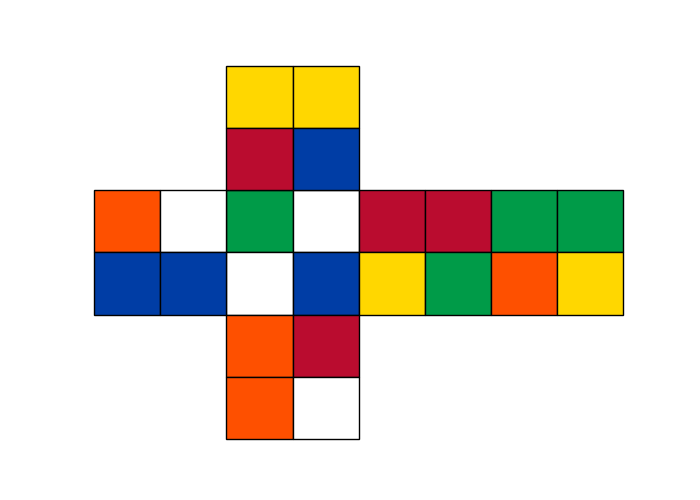

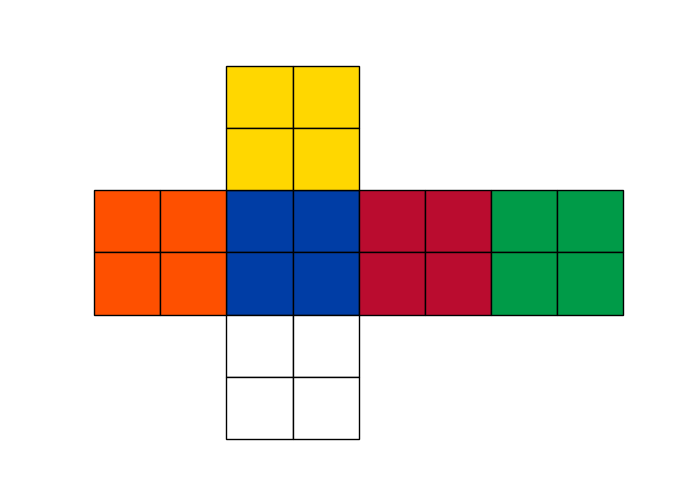

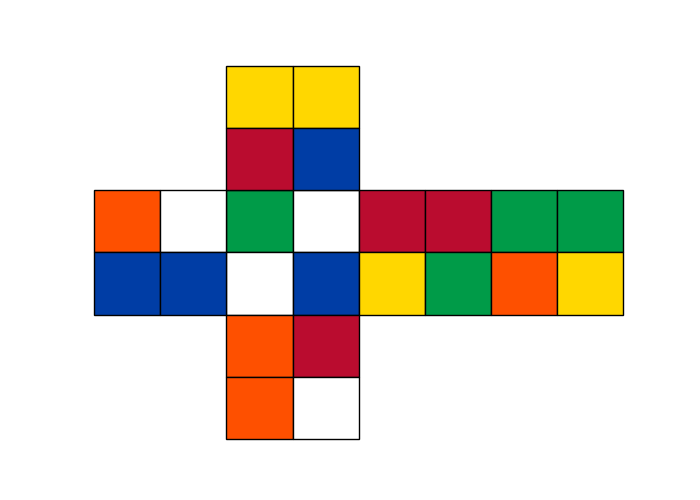

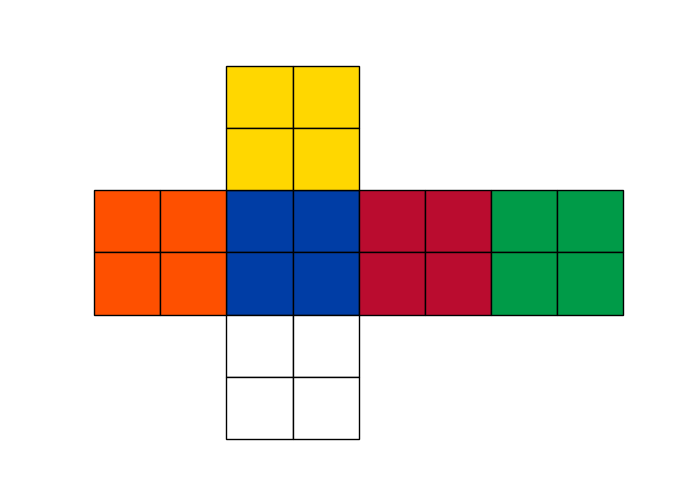

In [32]:

plt.close("all")

input = Cube(case1)
input.render()
cube, road = astar(input, heuristic)

p, m = road[cube.hash()]
path = [m]
while p:
    p, m = road[p.hash()]
    path.append(m)
cube.render()
input = Cube(case1)
input.render()

path.remove(None)
path.reverse()
for m in path:
    input = input.move(m)
input.render()

In [45]:
from ast import List
from multiprocessing import Process, Manager, Queue, Event
from typing import Dict
import numpy
def bfs(cube: Cube) -> Cube:
    curr_cube: Cube
    curr_cube_reversed: Cube

    direction = 1

    queue = [cube]
    discovered = {cube.hash(): (0, cube)}
    road = {cube.hash(): (None, None)}

    cube_reversed = cube.clone()
    aux = cube_reversed.state
    cube_reversed.state = cube_reversed.goal_state
    cube_reversed.goal_state = aux
    queue_reverse = [cube_reversed]

    discovered_reversed = {cube_reversed.hash(): (0, cube_reversed)}
    reversed_road = {cube_reversed.hash(): (None, None)}

    while queue and queue_reverse:

        if direction:
            curr_cube = queue.pop(0)

            if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
                # print("1End found")

                return curr_cube, curr_cube_reversed, road, reversed_road

            common_state, potential_cube  = discovered_reversed.get(cube.hash(), (False, None))
            c, _ = discovered[curr_cube.hash()]

            if common_state:
                # print("1common state")

                return curr_cube, potential_cube, road, reversed_road

            for m in Move:
                tentative_cube = curr_cube.move(m)
                if tentative_cube.hash() not in discovered:
                    queue.append(tentative_cube)
                    discovered[tentative_cube.hash()] = (c + 1, tentative_cube)
                    if tentative_cube.hash() not in road:
                        road[tentative_cube.hash()] = (curr_cube, m)
        else:
            curr_cube_reversed = queue_reverse.pop(0)
            # curr_cube_reversed.render()
            # print(curr_cube_reversed.state)
            # print(curr_cube_reversed.goal_state)
            if numpy.array_equal(curr_cube_reversed.state, curr_cube_reversed.goal_state):
                # print("2End found")
                return curr_cube, curr_cube_reversed, road, reversed_road

            common_state, potential_cube = discovered.get(curr_cube_reversed.hash(), (False, None))
            c, _ = discovered_reversed[curr_cube_reversed.hash()]

            if common_state:
                # print("2common state")
                return potential_cube, curr_cube_reversed, road, reversed_road

            for m in Move:
                tentative_cube = curr_cube_reversed.move(m)
                tentative_cube.goal_state = curr_cube_reversed.goal_state
                if tentative_cube.hash() not in discovered:
                    queue_reverse.append(tentative_cube)
                    discovered_reversed[tentative_cube.hash()] = (c + 1, tentative_cube)
                    if tentative_cube.hash() not in reversed_road:
                        reversed_road[tentative_cube.hash()] = (curr_cube_reversed, m)

        direction = direction ^ 1




def bfs_bidirectional(cube: Cube) -> Cube:
    return bfs(cube)

    # retCube = ret.get_nowait()
    # retCube2 = ret2.get() if not numpy.array_equal(retCube.state, retCube.goal_state) else None
    # return retCube, retCube2

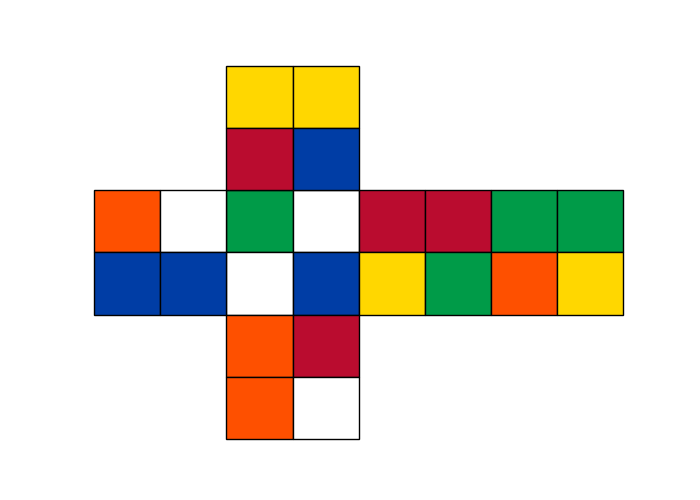

[2 5 5 0 1 1 4 2 2 2 3 4 3 5 0 0 4 4 1 0 3 1 3 5]


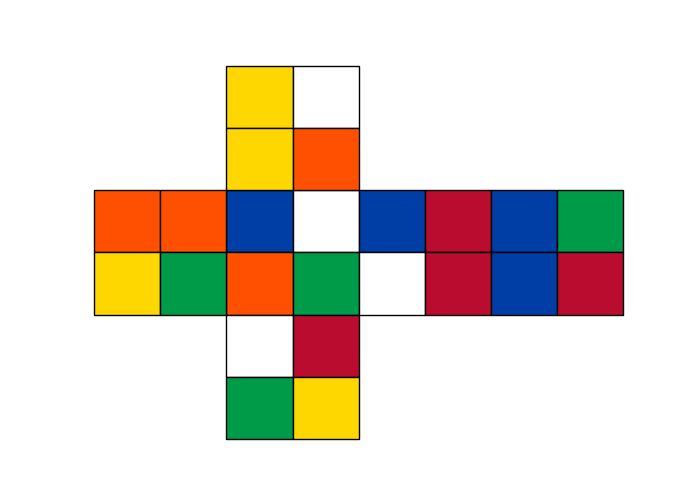

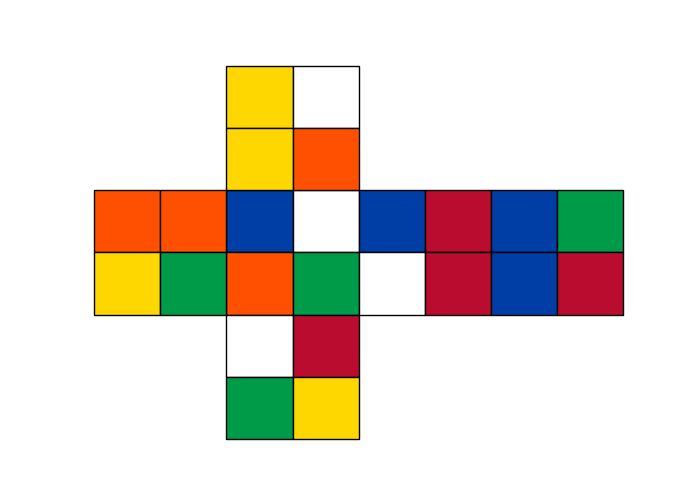

053201510201334245435124
[<Move.R: 0>, <Move.U: 2>, <Move.F: 1>, <Move.U: 2>]
[<Move.R: 0>, <Move.F: 1>, <Move.R: 0>]


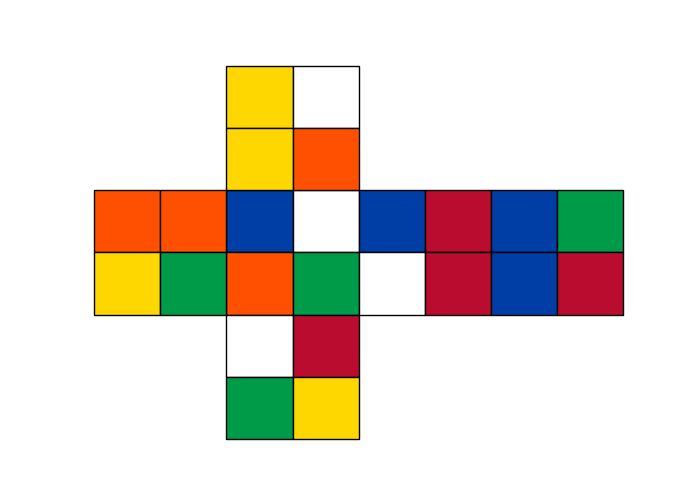

[0 5 3 2 0 1 5 1 0 2 0 1 3 3 4 2 4 5 4 3 5 1 2 4]
[0 5 3 2 0 1 5 1 0 2 0 1 3 3 4 2 4 5 4 3 5 1 2 4]


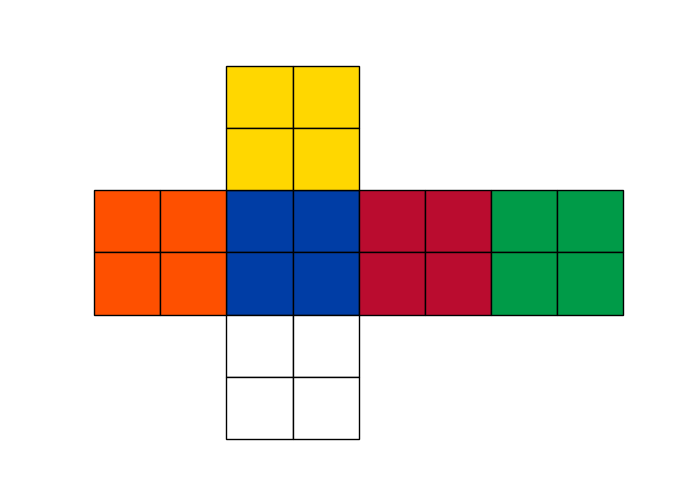

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]


In [63]:
plt.close("all")
from pprint import pprint
input = Cube(case1)
input.render()
print(input.state)
c1, c2, r1, r2 =bfs_bidirectional(input)
c1.render()
c2.render()
# for k, v in r2.items():
#     if v[0] == None:
#         continue
#     print(f"Key: {k} Value: {v[0].hash()} Move: {v[1].__str__()}")
print(c2.hash())
p1, m1 = r1[c1.hash()]
road = [m1]
while p1:
    p1, m1 = r1[p1.hash()]
    road.append(m1)

p2, m2 = r2[c2.hash()]
road_rev = [m2]
while p2:
    p2, m2 = r2[p2.hash()]
    road_rev.append(m2)
road.reverse()
road.remove(None)


road_rev.remove(None)
print(road)
print(road_rev)

input = Cube(case1)
for m in road:
    input = input.move(m)
input.render()
print(c1.state)
print(input.state)
assert numpy.array_equal(input.state, c1.state) == True

input = c2.clone()
for m in road_rev:
    input = input.move(m.opposite())
input.render()
print(c1.goal_state)
print(input.state)
assert numpy.array_equal(input.state, c1.goal_state) == True

In [ ]:
from cmath import log, sqrt


def select_action(node, c=CP):
    N_node = node[N]
    # Se caută acțiunea a care maximizează expresia:
    # Q_a / N_a  +  c * sqrt(2 * log(N_node) / N_a)
    #     {'N': 7, 'Q': 2.5, 'parent': None, 'actions': {0: {'N': 3, ...}, 1: {'N': 4, ...}}}
    max = None
    max_q = -1
    for k in node[ACTIONS]:
        a = node[ACTIONS][k]
        if a[PARENT] is not None:
            UCB = a[Q] / a[N] + c * sqrt(log(a[PARENT][N]) / a[N])
        else:
            UCB = a[Q] / a[Q]
        if UCB > max_q:
            max_q = UCB
            max = k

    return max


def select_move(
    cube: Cube,
    parents: Dict[str, Cube],
    visits: Dict[str, int],
    rewards: Dict[str, int],
    actions: Dict[str, List[Move]],
    c,
) -> Move:
    max = 0
    result = None
    for m in actions[cube.hash()]:
        new_cube = cube.move(m)
        new_cube_hash = new_cube.hash()
        if parents[new_cube.hash()] is not None:
            ucb = rewards[new_cube_hash] / visits[new_cube_hash] + c * sqrt(
                log(visits[parents[new_cube_hash]]) / visits[new_cube_hash]
            )
        else:
            ucb = rewards[new_cube_hash] / visits[new_cube_hash]
        if ucb > max:
            max = ucb
            result = m

    return result

def get_available_actions(cube: Cube, discovered):
    return [i for i in Move if cube.move(i).hash() not in discovered]

def monte_carlo(cube: Cube, budget: int, h) -> Cube:
    # DACĂ există un arbore construit anterior ȘI
    #   acesta are un copil ce corespunde ultimei acțiuni a adversarului,
    # ATUNCI acel copil va deveni nodul de început pentru algoritm.
    # ALTFEL, arborele de start este un nod gol, corespunzator adversarului (eu sunt la mutare si urmeaza
    # sa creez un nod copil al nodului radacina).

    # {'N': 7, 'Q': 2.5, 'parent': None, 'actions': {0: {'N': 3, ...}, 1: {'N': 4, ...}}}

    # ---------------------------------------------------------------

    mcts = {}
    visits = {}
    rewards = {}
    actions = {}
    discovered = {}
    N = "N"
    Q = "Q"
    PARENT = "parent"
    ACTIONS = "actions"
    for _ in range(budget):
        # Punctul de start al simulării va fi rădăcina de start
        curr_cube = cube.clone()

        # TODO <4>
        # Coborâm în arbore până când ajungem la o stare finală
        # sau la un nod cu acțiuni neexplorate.
        # Variabilele state și node se 'mută' împreună.
        parent = {}
        available_actions = get_available_actions(curr_cube, visits)
        while not curr_cube.state != curr_cube.goal_state and len(available_actions) <= len(actions[curr_cube.hash()]):
            m = select_move(curr_cube, visits, rewards)
            new_cube = curr_cube.move(m)
            parent[new_cube.hash()] = (curr_cube, m)
            curr_cube = new_cube
        # ---------------------------------------------------------------
        if curr_cube.state != curr_cube.goal_state:
            available_actions = get_available_actions(curr_cube, visits)
            available_actions = list(filter(lambda x: x not in actions[curr_cube.hash()], available_actions))

            new_node = curr_cube.move(available_actions[0])
            actions[curr_cube.hash()] = [available_actions[0]] + actions.get(curr_cube.hash(), [])

            curr_cube = new_node
        # ---------------------------------------------------------------

        # TODO <6>
        # Se simulează o desfășurare a jocului până la ajungerea într-o
        # starea finală. Se evaluează recompensa în acea stare.\
        timeout = 14

        while not curr_cube.state != curr_cube.goal_state and timeout > 0:
            valid = get_available_actions(curr_cube, visits)
            curr_cube = curr_cube.move(valid[0])
            timeout -= 0

        if curr_cube.state == curr_cube.goal_state:
            reward = 24
        else:
            reward = 24 - h(curr_cube)
        # ---------------------------------------------------------------

        while curr_cube:
            visits[curr_cube.hash()] = 1 + visits.get(curr_cube.hash(), 0)
            rewards[curr_cube.hash()] = reward + +rewards.get(curr_cube.hash(), 0)
            curr_cube = parent[curr_cube.hash()]

        # ---------------------------------------------------------------

    return cube